# ---  Usefull ``pip`` commands --- **[OPTIONAL]**


In [ ]:
'''
Run the command to know what is installed with
specific version and what is not on colab
'''
!pip freeze

In [ ]:
'''
Run the command to find out whether specific libraries
are installed or not

Template:
!pip show <library_name> <library_name> ...
'''
!pip show opencv-python ultralytics supervision

As the rest of libraries except ``ultralytics``, ``supervision`` are installed on colab, we need to install ``ultralytics`` and ``supervision``


```bash
!pip install ultralytics supervision
```



# We'll be using YOLOv12 models for our project
---
[![arXiv](https://img.shields.io/badge/arXiv-2502.12524-b31b1b.svg)](https://arxiv.org/abs/2502.12524)
[![GitHub](https://badges.aleen42.com/src/github.svg)](https://github.com/sunsmarterjie/yolov12)
[![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1pJ1IS706VL_9z1JyxrWkbJ0wVswHlR1c?usp=sharing)

# `YOLOv12`

It is a newly proposed attention-centric variant of the YOLO family that focuses on incorporating efficient attention mechanisms into the backbone while preserving real-time performance. Instead of relying heavily on CNN-based architectures like its predecessors, YOLOv12 introduces a simple yet powerful “area attention” module, which strategically partitions the feature map to reduce the quadratic complexity of full self-attention. It also adopts residual efficient layer aggregation networks (R-ELAN) to enhance feature aggregation and training stability, especially for larger models. These innovations, together with refinements such as scaled residual connections and a reduced MLP ratio, enable YOLOv12 to harness the benefits of attention (e.g., better global context modeling) without sacrificing speed.

![yolov12-area-attention](https://media.roboflow.com/notebooks/examples/yolov12-area-attention.png)

Compared to prior YOLO iterations (e.g., YOLOv10, YOLOv11, and YOLOv8), YOLOv12 achieves higher detection accuracy with competitive or faster inference times across all model scales. Its five sizes—N, S, M, L, and X—range from 2.6M to 59.1M parameters, striking a strong accuracy–speed balance. For instance, the smallest YOLOv12-N surpasses other “nano” models by over 1% mAP with latency around 1.6 ms on a T4 GPU, and the largest YOLOv12-X achieves 55.2% mAP, comfortably outscoring comparable real-time detectors such as RT-DETR and YOLOv11-X . By matching or exceeding state-of-the-art accuracy while remaining fast, YOLOv12 represents a notable step forward for attention-based real-time object detection.

![yolov12-metrics](https://storage.googleapis.com/com-roboflow-marketing/notebooks/examples/yolov12-metrics.png)

# Limitation of ``YOLOv12``

A current limitation of ``YOLOv12`` is its reliance on ``FlashAttention`` for optimal speed. ``FlashAttention`` is only supported on relatively modern GPU architectures (NVIDIA Turing, Ampere, Ada Lovelace, or Hopper families) such as ``Tesla T4``, ``RTX 20/30/40-series``, ``A100``, ``H100``, etc.

This means older GPUs that lack these architectures cannot fully benefit from YOLOv12’s optimized attention implementation. Users on unsupported hardware would have to fall back to standard attention kernels, losing some speed advantage.

# Check GPU availability

**NOTE:** ``YOLOv12`` leverages `FlashAttention` to speed up attention-based computations, but this feature requires an Nvidia GPU built from the above architectures or newer

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that.   

In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

**or** go to 🔽 button below ``share`` option, right beside `connect` -> `Change runtime type` -> `T4 GPU` -> `save`

In [3]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found



# `Project Goal:`

**The main goal of this project is to develop a system capable of accurately detecting and displaying the speed of vehicles in real-time from a video feed.**



> **[MUST RUN]** --> You need to run this to achieve the ``project goal``, some are added with main STEP headings, meaning you need to run all code blocks under it      

>**[OPTIONAL]** --> It is optional but important learning steps

# STEP 0: Download the dependencies **[MUST RUN]**

**NOTE:** Currently, `YOLOv12` does not have its own `PyPI` package, so we install it directly from GitHub while also adding `flash-attn` (to accelerate attention-based computations via optimized CUDA kernels) and `supervision` (to visualize inference results and benchmark the model’s performance)

Install the official ``YOLOv12`` repository from original authors

In [38]:
# It will also install all the requirements to run YOLOv12 models
# e.g. opencv-python, numpy, ultralytics, etc.
!pip install git+https://github.com/sunsmarterjie/yolov12.git

  Cloning https://github.com/sunsmarterjie/yolov12.git to /tmp/pip-req-build-rzu0mfx3
  Running command git clone --filter=blob:none --quiet https://github.com/sunsmarterjie/yolov12.git /tmp/pip-req-build-rzu0mfx3
  Resolved https://github.com/sunsmarterjie/yolov12.git to commit 2db2baea0f62e896ac85d4c412925a03136ddda7
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


Install ``flash-attn`` without build isolation to ensure it compiles against the currently installed PyTorch and CUDA versions on ``Colab``

> ``FlashAttention`` is integrated as a core optimization to enhance the model’s real-time object detection performance.

In [39]:
!pip install flash-attn --no-build-isolation

Install `supervision` which is **also** a helper library that makes it easy to draw the detection boxes, labels, and tracking lines onto the video frames.

In [40]:
!pip install supervision

## --- Download Data ---

In [47]:
# -O means "output document" or "output file"
# gdown is a lightweight Python package designed for downloading files from Google Drive public/sharing links.
!pip install gdown

# Download the image
!gdown https://drive.google.com/uc?id=1SOjAkIsL5Ma0Jn1LrFgbTyGk14KtCwEX -O /content/screenshot.png

# Download the video
!gdown https://drive.google.com/uc?id=1X6Z7KosRdXVXXMtrbq9TWsAm-UjS3TfB -O /content/input.mp4

Downloading...
From: https://drive.google.com/uc?id=1SOjAkIsL5Ma0Jn1LrFgbTyGk14KtCwEX
To: /content/screenshot.png
100% 3.13M/3.13M [00:00<00:00, 164MB/s]
Downloading...
From: https://drive.google.com/uc?id=1X6Z7KosRdXVXXMtrbq9TWsAm-UjS3TfB
To: /content/input.mp4
100% 12.3M/12.3M [00:00<00:00, 18.4MB/s]


## --- Configuration ---

In [56]:
MODEL_NAME = "yolov12l.pt"
SOURCE_VIDEO_PATH = "v1.mp4"
TARGET_VIDEO_PATH = "output.mp4"
SOURCE_IMAGE_PATH = "screenshot.png"

## --- Import Libraries ---

In [57]:
'''
Think of `opencv-python` as the entire toolbox, and `cv2` as the main tool
within that box that you grab to start working. It's a common convention
in many libraries where the package name for installation might differ
slightly from the module name used for importing.

Examples:
[1] You install Pillow, but import it as PIL
    # !pip install Pillow
    # import PIL
[2] You install scikit-learn, but you import it as sklearn
    # !pip install scikit-learn
    # import sklearn
'''
import cv2

import numpy as np
import supervision as sv
from ultralytics import YOLO

# tqdm library is used to show a progress bar
from tqdm.notebook import tqdm as notebook_tqdm

# deque (double-ended queue) is a data structure that allows for
# fast appends and pops from both ends. It is used to maintain a
# fixed-length history of positions for each tracked object.
from collections import defaultdict, deque

# Draw grid on the image for easy calculations **[OPTIONAL]**

> The frame here is a random screenshot of the video. Also the camera is shaky. So you might need to re-adjust the coordinates. Look for ``step 1.2`` for more detailes.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

# --- Image Dimensions ---
WIDTH = 1920
HEIGHT = 1080

frame = SOURCE_IMAGE_PATH # A random frame taken from the input video source

# --- Load the image ---
img = Image.open(frame) # upload the image on colab in folder and paste the name instead of 'i1.png'
img_array = np.array(img)

# --- Plot Setup ---
# You can change the graph size here
# This does not change the measurement
fig, ax = plt.subplots(figsize=(12, 6))

# Display the image as the background
ax.imshow(img_array, extent=[0, WIDTH, HEIGHT, 0])

# 1. Set the X-axis range (0 to WIDTH)
ax.set_xlim(0, WIDTH)

# 2. Set the Y-axis range (0 to HEIGHT)
ax.set_ylim(HEIGHT, 0)

# --- Add Grid Lines and Ticks ---
# Set major grid lines every 100 pixels
major_ticks_x = np.arange(0, WIDTH + 1, 100)
major_ticks_y = np.arange(0, HEIGHT + 1, 100)

ax.set_xticks(major_ticks_x)
ax.set_yticks(major_ticks_y)

# Set minor grid lines every 10 pixels for more granularity
minor_ticks_x = np.arange(0, WIDTH + 1, 10)
minor_ticks_y = np.arange(0, HEIGHT + 1, 10)

ax.set_xticks(minor_ticks_x, minor=True)
ax.set_yticks(minor_ticks_y, minor=True)

# Add the grid lines, making them more transparent
ax.grid(which='major', color='white', linestyle='-', linewidth=0.5, alpha=0.3)
ax.grid(which='minor', color='white', linestyle='-', linewidth=0.5, alpha=0.3)

# Move the x axis to top
ax.xaxis.tick_top()

plt.show()

# STEP 1: Detect and Track Objects

## STEP 1.1: Object Detection



### Custom color setup for specific ``class ID`` **[Optional]**

> For this case, I will change the color for cars





In [58]:
CAR_CLASS_ID = 2 # see ⭐ section under STEP 1.3

# --- Add more classes ---
# TRUCK_CLASS_ID = 7
# ...

# The default color set will be used for all other classes
colors = list(sv.ColorPalette.DEFAULT.colors)

# Create a dictionary that maps Class ID to the supervision Color object
colors[CAR_CLASS_ID] = sv.Color.ROBOFLOW

# --- Assign more colors to classes ---
# colors[TRUCK_CLASS_ID] = sv.Color.WHITE
# ...

# Differemt ways to assign colors
# [1] color=sv.Color.WHITE
# [2] color=sv.Color.from_hex('#ff00ff')
# [3] color=sv.Color(r=255, g=255, b=0)

# Create the final Color Palette list
custom_palette = sv.ColorPalette(colors=colors)

### Load the ``YOLOv12`` models **[MUST RUN]**

In [51]:
model = YOLO(MODEL_NAME) # Check Configuration Section

### Get ``video`` information to configure the ``output`` file **[MUST RUN]**

In [59]:
video_info = sv.VideoInfo.from_video_path(SOURCE_VIDEO_PATH)

### Set ``box`` and ``label`` annotation for the objects **[MUST RUN]**

> Do not forget to remove `color=custom_palette` if you do not want ``custom color`` for each class object

In [60]:
'''
remove `color=custom_palette` if you don't want to assign any custom colors
Also, you first need to run the previous block if you want to assign custom colors
'''
bounding_box_annotator = sv.BoxAnnotator(color=custom_palette) # Creates bounding box on each vehicle

# You can add parameters to change font size and color
label_annotator = sv.LabelAnnotator(color=custom_palette, text_thickness=2, text_scale=0., smart_position=True) # Creates label on each vehicle

### Code Snippet for ``Object Detection`` Only **[OPTIONAL]**

> Why we add ``frame.copy()`` for bounding box , but we add ``annotated_frame`` for label ? It is to ensure that the ``bounding boxes`` are drawn on a fresh copy of the original ``frame``, while the ``labels`` are drawn on the already ``annotated frame`` that includes the ``bounding boxes`` (To understand how label is used, see ``STEP 1.3`` ).

In [54]:
frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)

# --- Process video frame-by-frame ---
with sv.VideoSink(target_path=TARGET_VIDEO_PATH, video_info=video_info) as sink:

    '''
    Using notebook_tqdm to get the progress bar.
    If you do not want to use it, then update it to this,
    for frame in frame_generator:
    '''
    for frame in notebook_tqdm(frame_generator, total=video_info.total_frames):
        result = model(frame)[0] # yolov12l.pt detects objects
        detections = sv.Detections.from_ultralytics(result)

        # Explanation provided in the text block
        annotated_frame = bounding_box_annotator.annotate(
            scene=frame.copy(),
            detections=detections)

        # Write the Annotated Frame to the output file
        sink.write_frame(frame=annotated_frame)

  0%|          | 0/335 [00:00<?, ?it/s]


0: 384x640 9 cars, 1282.3ms
Speed: 5.9ms preprocess, 1282.3ms inference, 2.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 cars, 1272.4ms
Speed: 4.5ms preprocess, 1272.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 cars, 1849.4ms
Speed: 7.3ms preprocess, 1849.4ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 cars, 1328.5ms
Speed: 5.9ms preprocess, 1328.5ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 cars, 1194.9ms
Speed: 3.9ms preprocess, 1194.9ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 cars, 1201.9ms
Speed: 6.4ms preprocess, 1201.9ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 cars, 1218.0ms
Speed: 3.7ms preprocess, 1218.0ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 cars, 1195.4ms
Speed: 3.8ms preprocess, 1195.4ms inference, 1.2ms postprocess per image at

KeyboardInterrupt: 

## STEP 1.2: Source and Target ROI (Region of interest)

>Click ▶ [``TLDRAW``](https://www.tldraw.com/f/T6oHe2VW4S5P4fRhE0Aqv?d=v-4969.-631.2962.1407.-3ammlZr97oO5MAsfNS3P). I have provided the coordinate calculation and explanation for both ``SOURCE`` and ``TARGET``.

>``SOURCE`` coordinates might be re-adjusted based on the ``frame`` as the camera from the ``SOURCE video`` was shaking a lot. That is why, the ``ROI`` was changing a lot.

### ``SOURCE`` and ``TARGET`` Coordinates **[MUST RUN]**

> ``TARGET`` coordinates are kept realistic based on ``general info``. I might be wrong as I do not the real ``WIDTH`` and ``LENGTH`` of the road from the ``CAM angle``

In [61]:
SOURCE = np.array([
    [780, 170],
    [1170, 150],
    [2070,1210],
    [-50, 1210]
])

# Considered USA Roads
TARGET_WIDTH = 20
TARGET_HEIGHT = 144

TARGET = np.array([
    [0, 0],
    [TARGET_WIDTH - 1, 0],
    [TARGET_WIDTH - 1, TARGET_HEIGHT - 1],
    [0, TARGET_HEIGHT - 1]
])

### Visualize the ``polygone`` to know whether it is placed correctly or not **[OPTIONAL]**

> ``sv.get_video_frames_generator()`` gives you all frames for the video, ``iter()`` makes it possible to go through them one at a time, and ``next()`` gets the first frame. You can write a loop also.

In [18]:
frame_generator = sv.get_video_frames_generator(source_path=SOURCE_VIDEO_PATH)
frame = iter(frame_generator)
frame = next(frame)

Visualize the ``polygon`` (red boundary box) on an image ``frame`` by creating a copy of the ``frame``, drawing the ``polygon`` on it, and then displaying the annotated image.

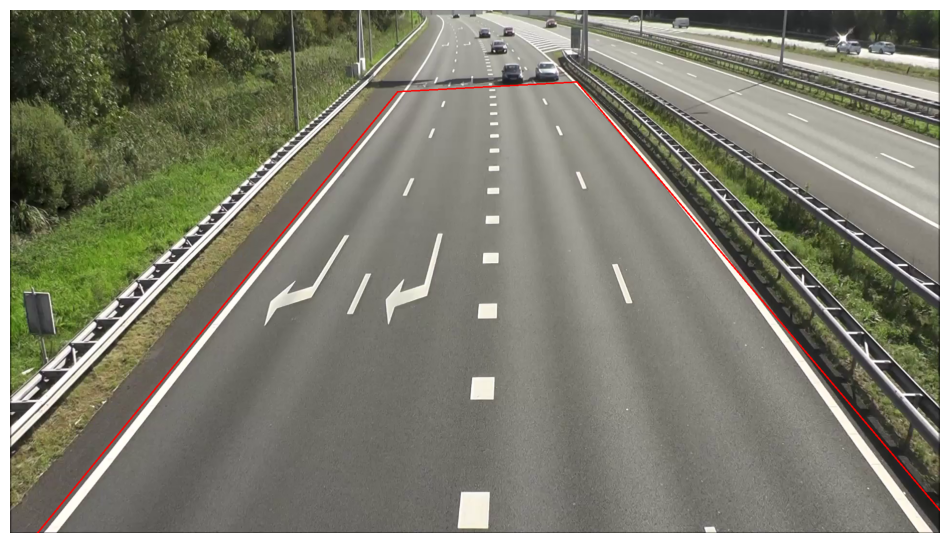

In [19]:
# Draw the polygon

polygon_frame = frame.copy()
polygon_frame = sv.draw_polygon(
    scene=polygon_frame,
    polygon=SOURCE,
    color=sv.Color.RED,
    thickness=2
)
sv.plot_image(polygon_frame)

> After proper calculations, we get the following result. I went to a white board to create the ``red`` border and coordinates ``A``, ``B``, ``C`` and ``D``. Click 👉 [``TLDRAW``](https://www.tldraw.com/f/T6oHe2VW4S5P4fRhE0Aqv?d=v-4969.-631.2962.1407.-3ammlZr97oO5MAsfNS3P) to see more details.

![SOURCE Coordinates](https://res.cloudinary.com/dd0tkhbsg/image/upload/v1759304806/coordinates_pc9xvp.png)

## STEP 1.3: Multi-Object Tracking

### Initiate tracker and filtering **[MUST RUN]**

> We will be using ``ByteTrack`` algorithm to track the vehicles. The class ``dataset`` is given after the following ``code block.``

In [62]:
# Initialize ByteTrack in Supervision
tracker = sv.ByteTrack()

# Initiate the polygon zone for filtering
polygon = sv.PolygonZone(polygon=SOURCE)

### Multiple Object Tracking inside the ROI **[OPTIONAL]**

In [ ]:
frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)

with sv.VideoSink(target_path=TARGET_VIDEO_PATH, video_info=video_info) as sink:
    for frame in notebook_tqdm(frame_generator, total=video_info.total_frames):
        results = model(frame)[0]  # Use model() for inference

        # Detects all objects
        detections = sv.Detections.from_ultralytics(results)

        # Starts tracking all detected objects
        detections = tracker.update_with_detections(detections=detections)

        # Starts filtering based on the polygon (ROI)
        # --- START ---
        # returns a NumPy array of boolean values, e.g., [False, True, False, ...]
        mask = polygon.trigger(detections=detections)
        # provides list of IDs of detections that are inside the polygon
        detections = detections[mask] # This is called NumPy Slicing
        # --- END ---

        # Start annotation on a clean frame copy
        annotated_frame = frame.copy()

        # Draw the Polygon
        annotated_frame = sv.draw_polygon(
            scene=annotated_frame,
            polygon=SOURCE,
            color=sv.Color(r=255, g=0, b=0), # Your desired red color
            thickness=2
        )

        # --- Create Labels and Annotate ---
        annotated_frame = bounding_box_annotator.annotate(
            scene=annotated_frame,
            detections=detections
        )
        # The labels list contains the ID for each vehicle
        labels = [f"{model.names[class_id]} #{tracker_id}"
                  for class_id, tracker_id in zip(detections.class_id, detections.tracker_id)]
                  # model.names is a dictionary mapping class_id (e.g., 0, 1) to class name (e.g., 'car', 'person')
                  # detections.class_id = [0, 0, 1] and detections.tracker_id = [1, 2, 1]
                  # so the zip will produce [(0, 1), (0, 2), (1, 1)]
                  # detections is an object that contains the results of the detection model
                  # .class_id is a list of class IDs for each detection
                  # .tracker_id is a list of unique tracker IDs for each detection
                  # iteration 1: class_id=0, tracker_id=1 -> label="car #1"
                  # iteration 2: class_id=0, tracker_id=2 -> label="car #2"

        # Explanation provided in STEP 1.1 for labels
        annotated_frame = label_annotator.annotate(
            scene=annotated_frame,
            detections=detections,
            labels=labels
        )

        # Write the Annotated frame to the output file
        sink.write_frame(frame=annotated_frame)

### ✨``Classes`` categorized based on ``COCO`` dataset

In [13]:
'''
names:
  0: person
  1: bicycle
  2: car
  3: motorcycle
  4: airplane
  5: bus
  6: train
  7: truck
  8: boat
  9: traffic light
  10: fire hydrant
  11: stop sign
  12: parking meter
  13: bench
  14: bird
  15: cat
  16: dog
  17: horse
  18: sheep
  19: cow
  20: elephant
  21: bear
  22: zebra
  23: giraffe
  24: backpack
  25: umbrella
  26: handbag
  27: tie
  28: suitcase
  29: frisbee
  30: skis
  31: snowboard
  32: sports ball
  33: kite
  34: baseball bat
  35: baseball glove
  36: skateboard
  37: surfboard
  38: tennis racket
  39: bottle
  40: wine glass
  41: cup
  42: fork
  43: knife
  44: spoon
  45: bowl
  46: banana
  47: apple
  48: sandwich
  49: orange
  50: broccoli
  51: carrot
  52: hot dog
  53: pizza
  54: donut
  55: cake
  56: chair
  57: couch
  58: potted plant
  59: bed
  60: dining table
  61: toilet
  62: tv
  63: laptop
  64: mouse
  65: remote
  66: keyboard
  67: cell phone
  68: microwave
  69: oven
  70: toaster
  71: sink
  72: refrigerator
  73: book
  74: clock
  75: vase
  76: scissors
  77: teddy bear
  78: hair drier
  79: toothbrush
  '''

'\nnames:\n  0: person\n  1: bicycle\n  2: car\n  3: motorcycle\n  4: airplane\n  5: bus\n  6: train\n  7: truck\n  8: boat\n  9: traffic light\n  10: fire hydrant\n  11: stop sign\n  12: parking meter\n  13: bench\n  14: bird\n  15: cat\n  16: dog\n  17: horse\n  18: sheep\n  19: cow\n  20: elephant\n  21: bear\n  22: zebra\n  23: giraffe\n  24: backpack\n  25: umbrella\n  26: handbag\n  27: tie\n  28: suitcase\n  29: frisbee\n  30: skis\n  31: snowboard\n  32: sports ball\n  33: kite\n  34: baseball bat\n  35: baseball glove\n  36: skateboard\n  37: surfboard\n  38: tennis racket\n  39: bottle\n  40: wine glass\n  41: cup\n  42: fork\n  43: knife\n  44: spoon\n  45: bowl\n  46: banana\n  47: apple\n  48: sandwich\n  49: orange\n  50: broccoli\n  51: carrot\n  52: hot dog\n  53: pizza\n  54: donut\n  55: cake\n  56: chair\n  57: couch\n  58: potted plant\n  59: bed\n  60: dining table\n  61: toilet\n  62: tv\n  63: laptop\n  64: mouse\n  65: remote\n  66: keyboard\n  67: cell phone\n 

## STEP 2: Transform Perspective



### Create Perspective Transformer Class **[MUST RUN]**

> We need to create ``class`` that will convert the angled perspective to bird's eye view

In [65]:
class ViewTransformer:

    def __init__(self, source: np.ndarray, target: np.ndarray) -> None:
        # Creating constructor that takes source and target points as input
        # When you create an instance of this class, you need to provide source and target points
        source = source.astype(np.float32)
        target = target.astype(np.float32)
        self.m = cv2.getPerspectiveTransform(source, target)

    def transform_points(self, points: np.ndarray) -> np.ndarray:
        # Check if the input points array is empty.
        # Why is this needed? Because cv2.perspectiveTransform fails on empty arrays
        if points.size == 0:
            return points

        '''
        cv2.perspectiveTransform expects points in shape (N, 1, 2). Also, we need
        to ensure the points are of type float32, as required by OpenCV functions.
        -1 in reshape is a special placeholder that tells NumPy to automatically calculate
        the size of that dimension based on the other dimensions and the total number of elements.
        e.g., if we have 10 points, reshaping to (-1, 1, 2) will result in (10, 1, 2)

        (-1, 1, 2) means "keep the first dimension (number of points)
        # as is, and reshape the last two dimensions to 1 and 2"
        '''
        reshaped_points = points.reshape(-1, 1, 2).astype(np.float32)
        transformed_points = cv2.perspectiveTransform(reshaped_points, self.m)
        # cv2.perspectiveTransform returns points in shape (N, 1, 2), so we need to reshape it back to (N, 2)
        return transformed_points.reshape(-1, 2)

> Initiate the ``ViewTransformer`` class

In [66]:
view_transformer = ViewTransformer(source=SOURCE, target=TARGET)

### Object coordinates after perspective transformation **[Optional]**

> Running this block, you can generate video with transformed ``x`` and ``y`` coordinates.

In [ ]:
frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)

with sv.VideoSink(target_path=TARGET_VIDEO_PATH, video_info=video_info) as sink:
  for frame in notebook_tqdm(frame_generator, total=video_info.total_frames):

      # 1. Detection, Tracking, and Filtering
      results = model(frame)[0]
      detections = sv.Detections.from_ultralytics(results)
      detections = tracker.update_with_detections(detections=detections)
      mask = polygon.trigger(detections=detections)
      detections = detections[mask]

      # 2. Get the bottom-center point of each bounding box that is touching the ground
      points = detections.get_anchors_coordinates(anchor=sv.Position.BOTTOM_CENTER)

      # 3. Transform the points from the image plane to the bird's-eye view (metric space)
      points = view_transformer.transform_points(points=points)

      # 4. Generate list of Class Name, Tracker ID, and Transformed Coordinates
      labels = [f"{model.names[class_id]} #{tracker_id}\nx: {point[0]:.0f}, y: {point[1]:.0f}"
                for class_id, tracker_id, point in zip(detections.class_id, detections.tracker_id, points)]

      # 5. Draw the ROI Polygon (Background Layer)
      annotated_frame = frame.copy()
      annotated_frame = sv.draw_polygon(
          scene=annotated_frame,
          polygon=SOURCE,
          color=sv.Color.RED,
          thickness=2
      )

      # 6. Annotate Bounding Boxes (Middle Layer)
      annotated_frame = bounding_box_annotator.annotate(scene=annotated_frame, detections=detections)

      # 7. Annotate Labels (Top Layer)
      annotated_frame = label_annotator.annotate(scene=annotated_frame, detections=detections, labels=labels)

      # 8. Write the frame to the video file
      sink.write_frame(frame=annotated_frame)


# STEP 3: Calculating Speed with Computer Vision **[MUST RUN]**


> ``defaultdict`` is a **subclass of the built-in dict class**. It overrides one method and adds one writable instance variable. The overridden method is ``__missing__(key)``, which is called by the ``__getitem__()`` method of the dict class when the requested key is not found. In a regular dictionary, if you try to access a key that doesn't exist, it raises a ``KeyError``. However, with ``defaultdict``, if you try to access a ``key`` that doesn't exist, it will automatically ``create`` an entry for that ``key`` using the default factory function provided.

Click 👉 [``TLDRAW``](https://www.tldraw.com/f/T6oHe2VW4S5P4fRhE0Aqv?d=v-4969.-631.2962.1407.-3ammlZr97oO5MAsfNS3P) to understand the logic of of the ``code snippet`` of speed.


In [ ]:
'''
coordinates varibale created a dictionary that maps each object ID to a deque of its
recent (x, y) positions, allowing us to track the movement of each object in the video.
'''

coordinates = defaultdict(lambda: deque(maxlen=video_info.fps))
# e.g., coordinates = {1: deque([3.4, 3.6, ...], maxlen=30), 2: deque([5.6, 5.8, ...], maxlen=30), ...}
# [3.4, 3.6, ...] is the y coordinates we added using .append() for each tracker_id

frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)

with sv.VideoSink(target_path=TARGET_VIDEO_PATH, video_info=video_info) as sink:
  for frame in notebook_tqdm(frame_generator, total=video_info.total_frames):

      # 1. Detection, Tracking, and Filtering
      results = model(frame)[0]
      detections = sv.Detections.from_ultralytics(results)
      detections = tracker.update_with_detections(detections=detections)
      mask = polygon.trigger(detections=detections)
      detections = detections[mask]

      # 2. Get the bottom-center point of each bounding box that is touching the ground
      points = detections.get_anchors_coordinates(anchor=sv.Position.BOTTOM_CENTER)

      # 3. Transform the points from the image plane to the bird's-eye view (metric space)
      points = view_transformer.transform_points(points=points)

      # 4. Speed Calculation and Data Storage (Main Goal)

      speeds = {} # We store the data so that we can add it in labels
      # what does speeds = {} look like in the end?
      # speeds = {
      #     1: 5.4,  # Speed for object with tracker ID 1
      #     2: 7.2   # Speed for object with tracker ID 2
      #     ...
      #     tracker_id: speed
      # }
      for tracker_id, [x, y] in zip(detections.tracker_id, points):
          # Store the current y-coordinate (distance)
          coordinates[tracker_id].append(y)
          # Check if enough data is available (e.g., at least 0.5 seconds of frames)
          # Kept it 15 frames as video_info.fps is 30, so 30/2 is 15
          if len(coordinates[tracker_id]) > video_info.fps / 2:
              # Calculate components
              coordinate_start = coordinates[tracker_id][-1] # Current Y-coordinate. -1 means the last y coordinate from list
              coordinate_end = coordinates[tracker_id][0]    # Oldest Y-coordinate in the deque. 0 means the first y coordinate from list
              distance = abs(coordinate_start - coordinate_end) # Just need the positive value
              time = len(coordinates[tracker_id]) / video_info.fps
              # Calculate Speed (m/s * 3.6 = km/h)
              speed = (distance / time) * 3.6
              # Store the calculated speed
              speeds[tracker_id] = speed

      # 5. Generate list of Class Name, Tracker ID, and Transformed Coordinates
      labels = [f"{model.names[class_id]} #{tracker_id}" +
                (f"\n{speeds[tracker_id]:.0f} km/h" if tracker_id in speeds else "\n-- km/h")
                for class_id, tracker_id in zip(detections.class_id, detections.tracker_id)]

      '''
      Optional --> Another way to write Step 5 for more clarity
      labels = []
      for class_id, tracker_id in zip(detections.class_id, detections.tracker_id):
          base = f"{model.names[class_id]} #{tracker_id}"
          speed_part = f"\n{speeds[tracker_id]:.0f} km/h" if tracker_id in speeds else "\n-- km/h"
          labels.append(base + speed_part)
      '''

      # 6. Draw the ROI Polygon (Background Layer)
      annotated_frame = frame.copy()
      annotated_frame = sv.draw_polygon(
          scene=annotated_frame,
          polygon=SOURCE,
          color=sv.Color.RED,
          thickness=2
      )

      # 7. Annotate Bounding Boxes (Middle Layer)
      annotated_frame = bounding_box_annotator.annotate(scene=annotated_frame, detections=detections)

      # 8. Annotate Labels (Top Layer)
      annotated_frame = label_annotator.annotate(scene=annotated_frame, detections=detections, labels=labels)

      # 9. Write the frame to the video file
      sink.write_frame(frame=annotated_frame)

  0%|          | 0/335 [00:00<?, ?it/s]


0: 384x640 9 cars, 1253.2ms
Speed: 4.7ms preprocess, 1253.2ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 cars, 1207.9ms
Speed: 4.1ms preprocess, 1207.9ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 cars, 1216.6ms
Speed: 5.9ms preprocess, 1216.6ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 cars, 1200.2ms
Speed: 4.7ms preprocess, 1200.2ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 cars, 1193.0ms
Speed: 3.9ms preprocess, 1193.0ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 cars, 1201.9ms
Speed: 3.7ms preprocess, 1201.9ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 cars, 1696.3ms
Speed: 6.1ms preprocess, 1696.3ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 cars, 1653.4ms
Speed: 9.4ms preprocess, 1653.4ms inference, 1.0ms postprocess per image at

# Thank you for learning with me 🥰

# Follow my [``Github``](https://github.com/amugoodbad229) for more ``tutorials`` like this and ``Tech News`` and don't forget to give a ⭐ on the ``projects`` I have created for ``educational purposes``.

# Have a great day! 🥳